# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [2]:
import pandas as pd
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [3]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all.head(5)

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

In [4]:
import numpy as np

In [5]:
%matplotlib inline

#### Подготовим данные. Приведем числа к нужному виду и т.д.

In [6]:
pr_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 6 columns):
Date            1988 non-null object
Open            1964 non-null object
ClosingPrice    1988 non-null object
DailyHigh       1986 non-null object
DailyLow        1986 non-null object
VolumePcs       1988 non-null int64
dtypes: int64(1), object(5)
memory usage: 93.3+ KB


In [7]:
pr_all.Open = pr_all.Open.astype(str).apply(lambda x: x.replace(',','.')).astype(np.double)
pr_all.ClosingPrice = pr_all.ClosingPrice.astype(str).apply(lambda x: x.replace(',','.')).astype(np.double)
pr_all.DailyHigh = pr_all.DailyHigh.astype(str).apply(lambda x: x.replace(',','.')).astype(np.double)
pr_all.DailyLow = pr_all.DailyLow.astype(str).apply(lambda x: x.replace(',','.')).astype(np.double)

In [8]:
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,133.43,132.60,133.90,132.00,16037970
1,07.12.2017,133.70,133.02,133.87,132.81,18198430
2,06.12.2017,133.33,134.00,134.29,132.91,14641730
3,05.12.2017,133.48,133.65,133.99,132.78,12684800
4,04.12.2017,133.01,133.77,134.00,131.93,17818980


#### Токенизируем тексты

In [9]:
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

df_tok = df.copy()
df_tok.text = df.text.str.lower()
df_tok.text = df.text.apply(words_only)
df_tok.loc[0].text

'Компания рассчитывает на решение по газовому спору с Украиной до конца декабря Газпром ожидает решения Стокгольмского арбитража по транзитному спору с украинским Нафтогазом не позднее февраля года хотя раньше компания прогнозировала что это произойдет до ноября Решение по взаимным искам об условиях поставок газа на Украину по мнению монополии суд может принять на месяц раньше до декабря года'

#### Лемматизируем тексты

In [10]:
from pymystem3 import Mystem

df_lem = df.copy()
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df_lem.text = df_tok.text.apply(lemmatize)
df_lem.loc[0].text

'компания рассчитывать на решение по газовый спор с украина до конец декабрь газпром ожидать решение стокгольмский арбитраж по транзитный спор с украинский нафтогаз не поздно февраль год хотя рано компания прогнозировать что это происходить до ноябрь решение по взаимный иск об условие поставка газ на украина по мнение монополия суд мочь принимать на месяц рано до декабрь год'

#### Удалим стоп слова

In [11]:
df_cleared = df.copy()
mystoplemmas = [
"алтухов","большой","бы","быть","в","весь","вот","все","всей","вы","говорить","год","да","для","до","еще","же","знать","и","из","к","как","который","мочь","мы","на","наш","не","него","нее","нет","них","но","о","один","она","они","оно","оный","от","ото","по","с","свой","себя","сказать","та","такой","только","тот","ты","у","что","это","этот","я"
]
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df_cleared.text = df_lem.text.apply(remove_stoplemmas) 
df_cleared.loc[0].text

'компания рассчитывать решение газовый спор украина конец декабрь газпром ожидать решение стокгольмский арбитраж транзитный спор украинский нафтогаз поздно февраль хотя рано компания прогнозировать происходить ноябрь решение взаимный иск об условие поставка газ украина мнение монополия суд принимать месяц рано декабрь'

#### Оставим только те дни, в которые были новости 

Объединим таблицы с новостями и с котировками

In [12]:
df_merged = pd.merge(df_cleared, pr_all, left_on='date', right_on='Date').drop('Date', axis=1)
df_merged.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,09.11.2017,компания рассчитывать решение газовый спор укр...,132.31,131.50,132.82,131.14,33869650
1,08.11.2017,предполагать Ъ газпром воспользоваться жалоба ...,132.00,132.30,133.94,131.58,39381960
2,01.11.2017,новый редакция американский санкция ставить по...,126.40,126.50,126.89,125.97,18232550
3,30.10.2017,становиться известно Ъ известный рынок риск-ме...,125.96,125.98,126.93,125.53,19263340
4,23.10.2017,новатэк через пять собираться запускать камчат...,127.05,126.80,127.47,126.37,17308800


Добавим столбец с оригинальными длинами текстов

In [13]:
df_merged["len_orig"] = df.text.apply(len)
df_merged.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,len_orig
0,09.11.2017,компания рассчитывать решение газовый спор укр...,132.31,131.50,132.82,131.14,33869650,419
1,08.11.2017,предполагать Ъ газпром воспользоваться жалоба ...,132.00,132.30,133.94,131.58,39381960,624
2,01.11.2017,новый редакция американский санкция ставить по...,126.40,126.50,126.89,125.97,18232550,834
3,30.10.2017,становиться известно Ъ известный рынок риск-ме...,125.96,125.98,126.93,125.53,19263340,436
4,23.10.2017,новатэк через пять собираться запускать камчат...,127.05,126.80,127.47,126.37,17308800,1270


In [14]:
df_merged["len_orig"].describe()

count    1159.000000
mean      769.454702
std       545.009405
min        85.000000
25%       405.500000
50%       581.000000
75%      1002.000000
max      4111.000000
Name: len_orig, dtype: float64

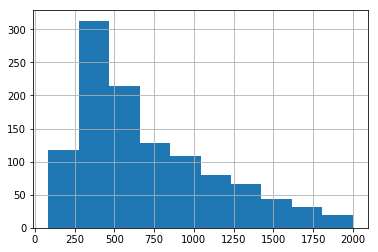

In [15]:
df_merged["len_orig"][df_merged["len_orig"] < 2000].hist()

#### Определим коэффициент корреляции Пирсона между длинной текста и ценой закрытия

In [16]:
df_merged["len_orig"].corr(df_merged["ClosingPrice"])

0.024107054173230204

Из чего можно сделать вывод что корреляция отсутствует

#### Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия?

In [17]:
df_merged.text[993]

'украина обязывать -летний контракт российский газпром ежегодно покупать определенный объем газ готовый продавать газ собственный добыча спотовый европейский рынок если россия заставлять киев купить объем газ превышать потребность страна если российский партнер предлагать закупать много газ чем нужно экономика просто взять газ сюда страна а газ перепродавать спот - министр энергетика угольный промышленность юрий бойко уточнять сомневаться газпром довольный появление конкурент европейский рынок оао газпром намерен инвестировать значительный сумма разведка нефть газ киргизия заявлять председатель правление российский газовый холдинг алексей миллер среда итог переговоры премьер-министр киргизия алмазбек атамбаев планировать объем инвестиция геологоразведка составлять первый этап менее млрд руб - он журналист руководство аэропорт кольцово екатеринбург направлять росрезерв официальный обращение выделение авиакеросин госрезерв сообщать пресс-служба авиапредприятие иметься запас авиакеросин о

In [18]:
df_merged["miller_count"] = df_merged.text.str.findall("алекс+[а-я]*\sмиллер | алекс | миллер").apply(len) #|[алекс]|[миллер]

In [19]:
df_merged[df_merged["miller_count"] > 0].head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,len_orig,miller_count
40,30.06.2017,газпром оспаривать промежуточный решение стокг...,118.86,118.49,120.22,118.18,22483610,868,2
53,30.05.2017,газпром сообщение встреча глава компания алекс...,122.72,122.10,122.91,121.79,16159700,1056,1
61,05.05.2017,газпром перехватывать инициатива борьба за суд...,133.68,134.41,134.94,132.91,26287190,389,1
115,16.12.2016,предправление газпром алексей миллер называть ...,158.48,156.20,158.88,156.20,31710640,585,1
146,21.09.2016,президент россия владимир путин поздравлять ро...,137.21,136.25,137.48,135.50,15958010,1454,1


In [20]:
df_merged["miller_count"].corr(df_merged["ClosingPrice"])

0.010635076467578003

Вывод - корреляция отсутствует

#### Упоминаний какого газопровода в статьях больше:
"северный поток"
"турецкий поток"?

In [21]:
df_merged["north_way"] = df_merged.text.str.findall("север+[а-я]*\sпоток").apply(len)

In [22]:
df_merged["north_way"].sum()

15

In [23]:
df_merged["turk_way"] = df_merged.text.str.findall("туре+[а-я]*\sпоток").apply(len)

In [24]:
df_merged["turk_way"].sum()

39

Вывод - о Турецком потоке говорили чаще

#### О каких санкциях пишут в статьях

In [25]:
df_sanc = df.copy()
df_sanc.text = df.text.str.lower()

In [26]:
df_sanc.head()

,date,text
0,09.11.2017,компания рассчитывает на решение по газовому с...
1,08.11.2017,"как и предполагал “ъ”, «газпром», воспользова..."
2,01.11.2017,новая редакция американских санкций ставит по...
3,30.10.2017,"как стало известно “ъ”, известный на рынке ри..."
4,23.10.2017,"новатэк, который через пять лет собирается за..."


In [27]:
sanc = df_sanc.text[df_sanc.text.str.findall("санкци+[а-я]*").apply(lambda x : len(x) > 0)]

Сохраним тексты содержащие слово санкции в файл, что бы потом отдать это в syntaxnet

In [28]:
with open('sancs.txt', "w") as f:
    for i in sanc:
#         print(i)
        f.write(i)
        f.write('\n')    

In [29]:
! cat sancs.txt | docker run --rm -i inemo/syntaxnet_rus > data_sanc.conll

2017-12-31 11:10:50.955998: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-31 11:10:50.956020: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-31 11:10:50.956055: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-31 11:10:50.956055: W external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-12-

2017-12-31 11:10:51.216288: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-31 11:10:51.226889: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-31 11:10:51.232739: I syntaxnet/term_frequency_map.cc:101] Loaded 31 terms from ./syntaxnet/models/Russian-SynTagRus/tag-map.
2017-12-31 11:10:52.357992: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building training network with parameters: feature_sizes: [12 20 20 20] domain_sizes: [    37     66     33 103475]
2017-12-31 11:10:52.573775: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Building training network with parameters: feature_sizes: [8 8 4 8 8 8 8 4 8] domain_sizes: [     7  18750      5   8502   8502   7249   7249    449 103

2017-12-31 11:10:54.169914: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-31 11:10:54.217678: I syntaxnet/term_frequency_map.cc:101] Loaded 18749 terms from ./syntaxnet/models/Russian-SynTagRus/char-ngram-map.
2017-12-31 11:10:54.823807: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2017-12-31 11:10:55.517792: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
2017-12-31 11:10:55.611616: I syntaxnet/term_frequency_map.cc:101] Loaded 103473 terms from ./syntaxnet/models/Russian-SynTagRus/word-map.
INFO:tensorflow:Processed 116 documents
INFO:tensorflow:Total processed documents: 116
INFO:tensorflow:num correct tokens: 0
INFO:tensorflow:total tokens: 6227
INFO:tensorflow:Seconds elapsed in evaluation: 4.95, eval metric: 0.00%
INFO:tensorflow:Processed 116 documents
INFO:tensorflow:Total p

In [30]:
from nltk import DependencyGraph
import codecs

In [31]:
processed_sentences = []
sentence = []
for line in codecs.open('data_sanc.conll', 'r', 'utf-8'):
    if len(line) == 1:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)
deps = []
res = []
for sentence in processed_sentences:
    s = u""
    for line in sentence:
        s += u"\t".join(line) + u'\n'
    deps.append(s)

for sent_dep in deps:    
    s_deps = sent_dep.split('\n')
    for t in s_deps:
        if len(t) > 1:
            splt = t.split('\t')
            if 'санкц' in splt[1]:
                n = int(splt[0]) 
                for t2 in s_deps:
                    splitted_sentence = t2.split('\t')
                    if len(splitted_sentence) > 1 :
                        word_type = splitted_sentence[3]
                        if word_type == 'ADJ' :
                            word = splitted_sentence[1]
                            print(word + "\n" + splt[1])
                            print()

новая
санкций

американских
санкций

зарубежные
санкций

нефтяные
санкций

российских
санкций

американским
санкций

определенных
санкций

нефтяных
санкций

российским
санкций

аналогичных
санкций

которые
санкций

российской
санкций

первую
санкций

аяшском
санкций

крупное
санкций

геологические
санкций

тонн,
санкций

тонн,
санкций

экономической
санкций

первую
санкций

аяшском
санкций

крупное
санкций

геологические
санкций

тонн,
санкций

тонн,
санкций

экономической
санкций

основным
санкций.

испанской
санкций.

новые
санкций.

сих
санкций.

добычные
санкций.

худайнатова,
санкций.

особой
санкций.

испанской
санкций.

паритетных
санкций.

комфортным
санкций.

основным
санкций.

испанской
санкций.

новые
санкций.

сих
санкций.

добычные
санкций.

худайнатова,
санкций.

особой
санкций.

испанской
санкций.

паритетных
санкций.

комфортным
санкций.

крупные
санкций,

лизинговые
санкций,

железнодорожных
санкций,

подвижной
санкций,

текущей
санкций,

рыболовных
санкций,

западных



американский
санкций,

американское
санкций,

долгосрочной
санкций,

кредитной
санкций,

кредитных
санкций,

процентную
санкций,

максимальный
санкций,

открытыми
санкций

долгосрочными
санкций

кредитными
санкций

американских
санкций

американский
санкций

американское
санкций

долгосрочной
санкций

кредитной
санкций

кредитных
санкций

процентную
санкций

максимальный
санкций

крупные
санкций

российские
санкций

очередной
санкций

новатэк,
санкций

публичном
санкций

независимые
санкций

серьезных
санкций

велики
санкций

первую
санкций

западными
санкций

которых
санкций

ключевые
санкций

прямого
санкций

совместных
санкций

крупные
санкции

российские
санкции

очередной
санкции

новатэк,
санкции

публичном
санкции

независимые
санкции

серьезных
санкции

велики
санкции

первую
санкции

западными
санкции

которых
санкции

ключевые
санкции

прямого
санкции

совместных
санкции

крупный
санкции

нефтегазовой
санкции

«стройтрансгаз-м»
санкции

который
санкции

черного
санкции

оао


## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

#### бинаризуйте признак "цена закрытия"

In [32]:
df_bin = pr_all.copy()

In [37]:
df_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 6 columns):
Date            1988 non-null object
Open            1964 non-null float64
ClosingPrice    1988 non-null float64
DailyHigh       1986 non-null float64
DailyLow        1986 non-null float64
VolumePcs       1988 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 93.3+ KB


In [42]:
bin = []
for i in range(len(df_bin) - 1):  
    row = df_bin.iloc[i]
    row_prev = df_bin.iloc[i+1]
    if row['ClosingPrice'] < row_prev['ClosingPrice']:  
        bin.append(0)
    else:
        bin.append(1)

bin.append(0)
df_bin["ClosingPrice_bin"] = bin        

1988


In [43]:
df_bin.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,08.12.2017,133.43,132.60,133.90,132.00,16037970,0
1,07.12.2017,133.70,133.02,133.87,132.81,18198430,0
2,06.12.2017,133.33,134.00,134.29,132.91,14641730,1
3,05.12.2017,133.48,133.65,133.99,132.78,12684800,0
4,04.12.2017,133.01,133.77,134.00,131.93,17818980,1


Оставим только те дни где есть новости

In [64]:
df_merged = pd.merge(df_cleared, df_bin, left_on='date', right_on='Date').drop('Date', axis=1)
df_merged.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,09.11.2017,компания рассчитывать решение газовый спор укр...,132.31,131.50,132.82,131.14,33869650,0
1,08.11.2017,предполагать Ъ газпром воспользоваться жалоба ...,132.00,132.30,133.94,131.58,39381960,1
2,01.11.2017,новый редакция американский санкция ставить по...,126.40,126.50,126.89,125.97,18232550,1
3,30.10.2017,становиться известно Ъ известный рынок риск-ме...,125.96,125.98,126.93,125.53,19263340,1
4,23.10.2017,новатэк через пять собираться запускать камчат...,127.05,126.80,127.47,126.37,17308800,1


#### составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Возьмем и в лоб найдем руками с какой строки начинается 2016 год, увидим что это 257 строка (11.01.2016) и разделим на обучающую и тестовую выборки

In [65]:
df_train = df_merged[258:].copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 258 to 1158
Data columns (total 8 columns):
date                901 non-null object
text                901 non-null object
Open                892 non-null float64
ClosingPrice        901 non-null float64
DailyHigh           901 non-null float64
DailyLow            901 non-null float64
VolumePcs           901 non-null int64
ClosingPrice_bin    901 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 63.4+ KB


In [66]:
df_train.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
258,29.12.2015,газпром отменять проведение рекордный история ...,135.26,137.49,137.55,134.74,21516980,1
259,25.12.2015,газпром прогнозировать увеличение чистый прибы...,136.49,134.48,136.49,134.03,14866310,0
260,24.12.2015,правительство приостанавливать обсуждение вопр...,135.85,136.00,138.08,134.45,36828650,1
261,23.12.2015,фас продолжать атака газпром соглашаться повыш...,133.55,135.30,135.30,133.35,26760910,1
262,22.12.2015,состоятельный банковский -клиент россия начина...,132.00,133.20,133.54,131.81,20022420,1


In [67]:
df_test = df_merged[:258].copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 257
Data columns (total 8 columns):
date                258 non-null object
text                258 non-null object
Open                253 non-null float64
ClosingPrice        258 non-null float64
DailyHigh           257 non-null float64
DailyLow            256 non-null float64
VolumePcs           258 non-null int64
ClosingPrice_bin    258 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 18.1+ KB


In [68]:
df_test.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,09.11.2017,компания рассчитывать решение газовый спор укр...,132.31,131.50,132.82,131.14,33869650,0
1,08.11.2017,предполагать Ъ газпром воспользоваться жалоба ...,132.00,132.30,133.94,131.58,39381960,1
2,01.11.2017,новый редакция американский санкция ставить по...,126.40,126.50,126.89,125.97,18232550,1
3,30.10.2017,становиться известно Ъ известный рынок риск-ме...,125.96,125.98,126.93,125.53,19263340,1
4,23.10.2017,новатэк через пять собираться запускать камчат...,127.05,126.80,127.47,126.37,17308800,1


Используйте любой известный вам алгоритм классификации текстов для того, Используйте  tf−idftf−idf  преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  tf−idftf−idf  преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации. Если у выбранного вами алгоритма есть гиперпараметры (например,  αα  в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

Переведем документы в векторы признаков:

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.text)
X_train_counts.shape

(901, 6027)

In [84]:
from sklearn.metrics import *
def metrics_test(predicted, target):
    acc = accuracy_score(predicted, target)
    micro_f1 = f1_score(predicted, target, average = 'micro')
    micro_p = f1_score(predicted, target, average = 'micro')
    micro_r = f1_score(predicted, target, average = 'micro')
    macro_f1 = f1_score(predicted, target, average = 'macro')
    macro_p = f1_score(predicted, target, average = 'macro')
    macro_r = f1_score(predicted, target, average = 'macro')
    print('acc={0:1.4f}'.format(acc))
    print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
    print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

#### Мультиномиальный наивный Байес

In [85]:
from sklearn.naive_bayes import MultinomialNB

Тренируем

In [88]:
clf = MultinomialNB().fit(X_train_counts, df_train.ClosingPrice_bin)

Предсказываем

In [90]:
X_test = count_vect.transform(df_test.text)
predicted = clf.predict(X_test)

In [91]:
metrics_test(predicted, df_test.ClosingPrice_bin)

acc=0.4341
micro F1=0.4341, micro P=0.4341, micro R=0.4341
macro F1=0.4340, macro P=0.4340, macro R=0.4340



#### Логистическая регрессия

In [93]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_counts, df_train.ClosingPrice_bin)
predicted = clf.predict(X_test)

In [94]:
metrics_test(predicted, df_test.ClosingPrice_bin)

acc=0.4767
micro F1=0.4767, micro P=0.4767, micro R=0.4767
macro F1=0.4765, macro P=0.4765, macro R=0.4765



#### Сеть прямого распространения - FNN

In [149]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [150]:
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 100
DIMS = 250
MAX_FEATURES = 5000
batch_size = 32

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 20

In [151]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_train.text)
sequences = tokenizer.texts_to_sequences(df_train.text)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(df_test.text)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [152]:
y_train = df_train.ClosingPrice_bin.values

In [153]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 810 samples, validate on 91 samples
Epoch 1/20
810/810 [==============================] - 1s 1ms/step - loss: 0.7115 - acc: 0.4802 - val_loss: 0.7109 - val_acc: 0.5604
Epoch 2/20
810/810 [==============================] - 0s 243us/step - loss: 0.4645 - acc: 0.9160 - val_loss: 0.7404 - val_acc: 0.5934
Epoch 3/20
810/810 [==============================] - 0s 257us/step - loss: 0.3083 - acc: 0.9679 - val_loss: 0.7852 - val_acc: 0.5934
Epoch 4/20
810/810 [==============================] - 0s 257us/step - loss: 0.1891 - acc: 0.9914 - val_loss: 0.8201 - val_acc: 0.5714
Epoch 5/20
810/810 [==============================] - 0s 236us/step - loss: 0.1158 - acc: 0.9963 - val_loss: 0.8975 - val_acc: 0.5824
Epoch 6/20
810/810 [==============================] - 0s 228us/step - loss: 0.0727 - acc: 0.9975 - val_loss: 0.9725 - val_acc: 0.5824
Epoch 7/20
810/810 [==============================] - 0s 239us/step - loss: 0.0488 - acc: 0.9988 - val_loss: 1.0571 - val_acc: 0.5495
Epoch 8/20
810/810 

In [154]:
predicted = model.predict_classes(X_test)

258/258 [==============================] - 0s 288us/step


In [155]:
predicted = predicted.flatten()

In [156]:
metrics_test(predicted, df_test.ClosingPrice_bin)

acc=0.4884
micro F1=0.4884, micro P=0.4884, micro R=0.4884
macro F1=0.4873, macro P=0.4873, macro R=0.4873



In [157]:
print(classification_report(df_test.ClosingPrice_bin, predicted))

             precision    recall  f1-score   support

          0       0.53      0.49      0.51       140
          1       0.45      0.48      0.46       118

avg / total       0.49      0.49      0.49       258



#### CNN

In [165]:
sequences = tokenizer.texts_to_sequences(df_train.text)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(df_test.text)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [166]:
y_train = df_train.ClosingPrice_bin.values

In [167]:
X_train.shape

(901, 1800)

In [197]:
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

embedding_layer = Embedding(VOCABULARY_SIZE,
                            EMBEDDING_DIM,
                            input_length=TEXT_LENGTH,
                            trainable=True)


sequence_input = Input(shape=(TEXT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(32, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 5)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

In [198]:
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=64, validation_split=0.1)

Train on 810 samples, validate on 91 samples
Epoch 1/20
810/810 [==============================] - 11s 14ms/step - loss: 0.6938 - acc: 0.5049 - val_loss: 0.6934 - val_acc: 0.4835
Epoch 2/20
810/810 [==============================] - 9s 12ms/step - loss: 0.6942 - acc: 0.4901 - val_loss: 0.6934 - val_acc: 0.4835
Epoch 3/20
810/810 [==============================] - 10s 12ms/step - loss: 0.6930 - acc: 0.5160 - val_loss: 0.6931 - val_acc: 0.5275
Epoch 4/20
810/810 [==============================] - 10s 12ms/step - loss: 0.6941 - acc: 0.4840 - val_loss: 0.6933 - val_acc: 0.4835
Epoch 5/20
810/810 [==============================] - 10s 12ms/step - loss: 0.6931 - acc: 0.4951 - val_loss: 0.6935 - val_acc: 0.4835
Epoch 6/20
810/810 [==============================] - 10s 13ms/step - loss: 0.6931 - acc: 0.5049 - val_loss: 0.6940 - val_acc: 0.4835
Epoch 7/20
810/810 [==============================] - 11s 13ms/step - loss: 0.6931 - acc: 0.5074 - val_loss: 0.6937 - val_acc: 0.4835
Epoch 8/20
810/810

In [199]:
predicted = model.predict(X_test)

In [203]:
def probs_to_classes(probas):
    classes = np.zeros(probas.shape, dtype=np.int)
    for i, row in enumerate(probas):
        if row > 0.5 :
            classes[i] = 1
    return classes

y_pred = probs_to_classes(predicted)

In [204]:
metrics_test(y_pred, df_test.ClosingPrice_bin)

acc=0.5543
micro F1=0.5543, micro P=0.5543, micro R=0.5543
macro F1=0.4338, macro P=0.4338, macro R=0.4338



In [207]:
print(classification_report(df_test.ClosingPrice_bin, y_pred))

             precision    recall  f1-score   support

          0       0.55      0.94      0.69       140
          1       0.57      0.10      0.17       118

avg / total       0.56      0.55      0.46       258



## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

#### Подготовим словарь и корпус

In [307]:
from gensim.corpora import *
texts = [df_merged.text.iloc[i].split() for i in range(len(df_merged))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [308]:
from gensim.models import  *
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#### Попробуем обучить систему на моделях скрытых тем

In [309]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [310]:
corpus_lsi = lsi[corpus_tfidf]

In [311]:
def add_arr_to_model(corpus):
    arr = np.array([])
    for doc in corpus: # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
        max_clazz = 0
        max_pred = 0
        for clazz, pred in doc:
            if pred > max_pred:
                max_pred = pred
                max_clazz = clazz
        arr = np.append(arr, max_clazz)
    return arr    

In [312]:
arr_lsi = add_arr_to_model(corpus_lsi)

In [326]:
print(arr_lsi[:10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [314]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10,
                        alpha='auto', eta='auto', iterations = 20, passes = 10)

In [315]:
corpus_lda = lda[corpus]

In [316]:
arr_lda = add_arr_to_model(corpus_lda)

In [317]:
print(arr_lda[:10])

[ 3.  7.  2.  5.  3.  5.  3.  8.  4.  8.]


In [318]:
arr = np.vstack((arr_lsi , arr_lda))

In [319]:
arr = arr.T

In [320]:
arr.shape

(1159, 2)

In [322]:
arr_train = arr[258:]
arr_test = arr[:258]

Натренируем Мультиномиальный наивный Байес, на темах полученных с помощью методов LSI & LDA

In [327]:
clf = MultinomialNB().fit(arr_train, df_train.ClosingPrice_bin)

Предсказываем

In [328]:
predicted = clf.predict(arr_test)

In [329]:
metrics_test(predicted, df_test.ClosingPrice_bin)

acc=0.5116
micro F1=0.5116, micro P=0.5116, micro R=0.5116
macro F1=0.4597, macro P=0.4597, macro R=0.4597



#### Так же ситуация, кога на основе сгененрированных тем пробуем делать предсказания с помощью сети прямого распространения - FNN

In [348]:
y_train = df_train.ClosingPrice_bin.values

In [347]:
arr_train.shape

(901, 2)

In [339]:
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(arr_train, y_train, epochs=nb_epoch, batch_size=8,  validation_split=0.1)

Train on 810 samples, validate on 91 samples
Epoch 1/20
810/810 [==============================] - 1s 1ms/step - loss: 0.7036 - acc: 0.5099 - val_loss: 0.6850 - val_acc: 0.5275
Epoch 2/20
810/810 [==============================] - 0s 344us/step - loss: 0.7076 - acc: 0.4938 - val_loss: 0.6936 - val_acc: 0.4835
Epoch 3/20
810/810 [==============================] - 0s 333us/step - loss: 0.7036 - acc: 0.4741 - val_loss: 0.6901 - val_acc: 0.5055
Epoch 4/20
810/810 [==============================] - 0s 340us/step - loss: 0.7016 - acc: 0.5012 - val_loss: 0.6934 - val_acc: 0.4835
Epoch 5/20
810/810 [==============================] - 0s 341us/step - loss: 0.7049 - acc: 0.4704 - val_loss: 0.6908 - val_acc: 0.5604
Epoch 6/20
810/810 [==============================] - 0s 367us/step - loss: 0.7028 - acc: 0.5210 - val_loss: 0.7080 - val_acc: 0.4835
Epoch 7/20
810/810 [==============================] - 0s 370us/step - loss: 0.7001 - acc: 0.4877 - val_loss: 0.6935 - val_acc: 0.5055
Epoch 8/20
810/810 

In [340]:
predicted = model.predict_classes(arr_test)

258/258 [==============================] - 0s 633us/step


In [341]:
predicted = predicted.flatten()

In [342]:
metrics_test(predicted, df_test.ClosingPrice_bin)

acc=0.5388
micro F1=0.5388, micro P=0.5388, micro R=0.5388
macro F1=0.3649, macro P=0.3649, macro R=0.3649



In [343]:
print(classification_report(df_test.ClosingPrice_bin, predicted))

             precision    recall  f1-score   support

          0       0.54      0.98      0.70       140
          1       0.40      0.02      0.03       118

avg / total       0.48      0.54      0.39       258

